-- Take satellite tracks from satellite analysis and interpolate model fields to these points at each 5 day snapshot. Export the resulting SSH and treat at satellite in filtering library

Goal: Compare resulting KE estimate to actual model KE 

Problem: Current model resolution is 1/4 degree so if going to estimate KE from SSH gradients will be extremely coarse 
-- for now interpolate sqrt(KE) onto satellite tracks representing a speed like that calculated from along-track gradients 

The code below is run to interpolate and extract model surface fields to then process as we do with altimeter measurements 

In [12]:
import pickle 
import numpy as np
from scipy.interpolate import griddata 
import cmocean
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import xarray as xr

In [5]:
# load dataset
x1 = xr.open_dataset('/Users/jakesteinberg/Desktop/neverworld/snapshots_00032505.nc', decode_times=False)
# -- load in a few variables 
lat = x1.yh.values
lon = x1.xh.values
time = x1.time.values

In [15]:
# satellite tracks on model 
this_sat = 'j2'
filter_type = 'sharp'
load_sat = pickle.load(open('/Users/jakesteinberg/Documents/CPT/altimetry/' + \
                            this_sat + '_' + filter_type + '_processed.p', 'rb'))
lon_sat = load_sat['lon_record']
lat_sat = load_sat['lat_record']
track_sat = load_sat['track']

lon_w = 10
lon_e = 45
lat_s = -60
lat_n = -25
Lon, Lat = np.meshgrid(lon, lat)
Lon_f = Lon.flatten()
Lat_f = Lat.flatten()
points = np.concatenate((Lon_f[:, None], Lat_f[:, None]), axis=1)

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in greater
/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in less


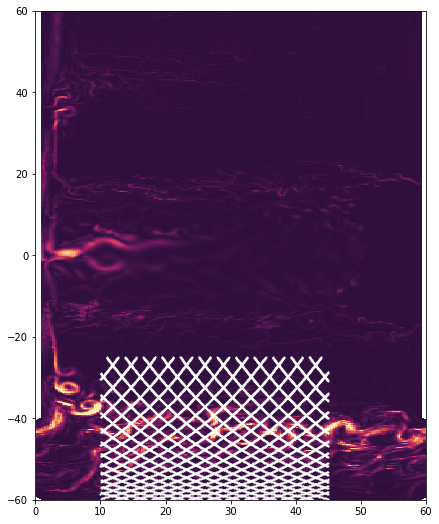

In [52]:
# --- plot and interpolate ssh (or say KE) to satellite lat/lon positions
# - say that satellite grid pattern is completed every time step...or every 5 days 
# - model fields are snapshots
lon_sim = []
lat_sim = []
dist_sim = []
e_sim = []
track = []
this_var = x1.e.values[:, 0, :, :]
time_steps_i = 20  # !!!!!!!!!!!!! np.shape(this_var)[0]  # each step is 5 days 

count = 0
for i in tqdm(range(len(lon_sat) )):  # len(lon_sat)  
    # satellite lon,lat coordinates (consider places on coarser grid...now on 10 km grid)
    this_lon = (lon_sat[i] - 360) + 60
    this_lat = -1.0 * lat_sat[i]
    lon_lat_in = np.where((this_lon > lon_w) & (this_lon < lon_e) & (this_lat > lat_s) & (this_lat < lat_n))[0]
    if (len(lon_lat_in) > 20):
        # ax.scatter(this_lon[lon_lat_in], this_lat[lon_lat_in], s=1, color='w', zorder=2)
        # lat/lon
        lon_sim.append(this_lon[lon_lat_in])
        lat_sim.append(this_lat[lon_lat_in])
        
        dx = np.nan * np.ones(len(lat_sim[count]) - 1)
        dy = np.nan * np.ones(len(lat_sim[count]) - 1)
        for k in range(1, len(lat_sim[count])):
            dx[k - 1] = 1852 * 60 * np.cos(np.deg2rad(lat_sim[count][k])) * (lon_sim[count][k] - lon_sim[count][k - 1])
            dy[k - 1] = 1852 * 60 * (lat_sim[count][k] - lat_sim[count][k - 1]) 
        dist = np.concatenate((np.array([0]), np.sqrt(np.cumsum(dx)**2 + np.cumsum(dy)**2)))
        dist_sim.append(dist)
        
        # variable we want to interpolate 
        this_e = np.nan * np.ones((np.shape(this_var)[0], len(this_lon[lon_lat_in])))
        for j in range(time_steps_i):  # loop over each time step 
            # values = np.squeeze(e[j, 0, :, :]).flatten()
            values = np.squeeze(this_var[j, :, :]).flatten()
            this_e[j, :] = griddata(points, values, \
                                    np.concatenate((this_lon[lon_lat_in][:, None], this_lat[lon_lat_in][:, None]), \
                                                   axis=1))
        track.append(track_sat[i])
        e_sim.append(this_e)
        count = count + 1
        

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in greater
  
/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: invalid value encountered in less
  


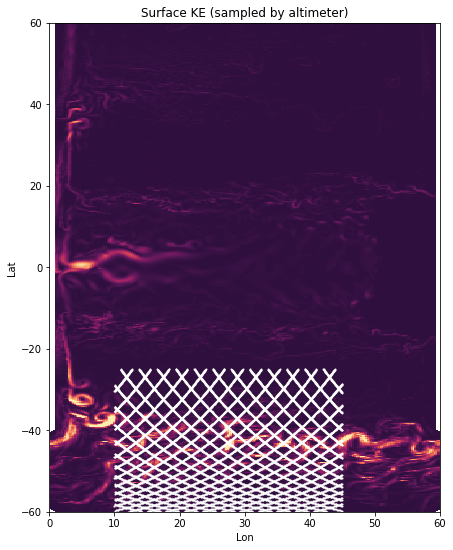

In [199]:
f, ax = plt.subplots(1, 1, figsize=(7,9))
levs = np.linspace(7*10**(-8), 7*10**(-1), 100)
ax.pcolormesh(x1.xh, x1.yh, x1.KE.values[-1, 0], cmap = cmocean.cm.matter_r, \
              zorder=0, vmin=levs[0], vmax=levs[-1])
for i in tqdm(range(len(lon_sat))):
    this_lon = (lon_sat[i] - 360) + 60
    this_lat = -1.0 * lat_sat[i]
    lon_lat_in = np.where((this_lon > lon_w) & (this_lon < lon_e) & (this_lat > lat_s) & (this_lat < lat_n))[0]
    if (len(lon_lat_in) > 20):
        ax.scatter(this_lon[lon_lat_in], this_lat[lon_lat_in], s=1, color='w', zorder=2)
ax.set_xlim([0, 60])
ax.set_ylim([-60, 60])
ax.set_xlabel('Lon')
ax.set_ylabel('Lat')
ax.set_title('Surface KE (sampled by altimeter)')
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/neverworld/neverworld_altim_tracks.jpg', dpi=300)

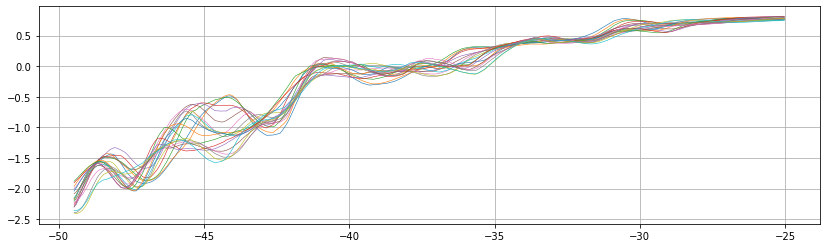

In [53]:
test_i = 0
f, ax = plt.subplots(1, 1, figsize=(14, 4))
for i in range(np.shape(e_sim[test_i])[0]):
    # ax.plot(dist_sim[test_i]/1000,np.sqrt(e_sim[test_i][i, :]), linewidth=0.6)
    ax.plot(lat_sim[test_i], e_sim[test_i][i, :], linewidth=0.6)
ax.grid()
plt.show()

In [59]:
save_sim = 1
if save_sim:
    outputs = {'dist': dist_sim, \
               'e': e_sim, \
                'time': time, \
                'lon': lon_sim, \
                'lat': lat_sim, \
                'track': track}
    pickle.dump(outputs, open('/Users/jakesteinberg/Desktop/neverworld/j2_simulated_e.p', 'wb'))

Now take simulated measurements and processes as we do real measurements 

In [56]:
from altimetry_tools import interpolate_nans, parse_grid_tracks, smooth_tracks
from altimetry_tools import coarsen, specsharp, sharp_smooth, spectra_slopes

In [61]:
dist_sim[10][20] - dist_sim[10][19]

9997.895936047833

In [88]:
# variables = 
# dist  [should have same spacing as lat/lon altimeter grid == 10 km]
# lon_sim
# lat_sim
# e
dist = []
for i in range(len(dist_sim)):
    dist.append(dist_sim[i]/1000.0)
adt = e_sim.copy()
f_type = 'sharp'
hor_grid_spacing = 10         # km, grid to which to interpolate tracks
interp_cutoff = 10           # number of acceptable nan gaps in grid cell units across which to interpolate
# ** choose here to match filter scales in neverworld_snapshot_2dfilt.ipynb
coarsening_factor0 = 5       # (*hor_grid_spacing = coarsened grid size) this factor should be multiplied by hor_grid_spacing 
nyquist_wavelength = np.pi   # factor relative to coarsening factor (what scales do we want to resolve...pi times the grid scale) 

In [89]:
# -- SMOOTH (the one/main iteration if not smoothing at multiple scales)
sla_smooth, adt_smooth = smooth_tracks(dist, adt, adt, lon_sim, lat_sim, time, track, \
                                       coarsening_factor0, f_type, nyquist_wavelength)
# -- COARSEN 
dist_coarse, lon_coarse, lat_coarse, adt_coarse = coarsen(dist, lon_sim, lat_sim, coarsening_factor0, adt_smooth)

Filter Half-Width = 
6 [0.12327988 0.11895676 0.1065763  0.08779966]
7 [0.12326621 0.11894309 0.10656263 0.08778599]
converged //
------------------------------------------------------------
for a coarsening factor of 5, recommend:
-- filter width of 15 grid cells (here = 149.8987514782786 km)
------------------------------------------------------------


/Users/jakesteinberg/Documents/CPT/altimetry_tools.py:395: RuntimeWarning: Mean of empty slice
  (this_dist < coarse_grid[j])], axis=1)


In [90]:
# cross track velocity (from sla or adt)  # run for 'raw' or smoothed    
def velocity(dist, sla, lon_record, lat_record, track_record):   
    vel = []
    grad = []
    count = 0
    for m in tqdm(range(len(track_record))):
        # -- load in data for this track 
        this_sla = sla[m]  # interpolated field   
        lon_grid = lon_record[m]
        lat_grid = lat_record[m]
        d_grid = dist[m]
        these_cycles = np.arange(0, np.shape(this_sla)[0])
                  
        if len(d_grid) < 10:
            print('track ' + str(m) + ', too short') 
            grad.append(np.nan * np.ones(np.shape(this_sla)))
            vel.append(np.nan * np.ones(np.shape(this_sla)))
            continue
    
        grid_space = d_grid[1] - d_grid[0]
            
        # -- gradient (of interpolated field)
        # (pol_rad = 6378.137km) (eq_rad = 6356.752km) 
        f_loc = 2*(7.27*10**(-5))*np.sin(np.deg2rad(lat_grid))    
        
        # estimate gradient from Arbic 2012 
        sla_grad = np.gradient(this_sla, d_grid*1000.0, axis=1)
        for cdm in range(4, 4 + len(sla_grad[0, 4:-3])):
            # -- gradients from a 7 point stencil 
            sla_grad[:, cdm] = (this_sla[:, cdm+3] - 9*this_sla[:, cdm+2] + 45*this_sla[:, cdm+1] \
                                - 45*this_sla[:, cdm-1] + 9*this_sla[:, cdm-2] - this_sla[:, cdm-3]) / (60*(grid_space*1000.0))   
            
            # -- gradients from a 5 point stencil 
            # sla_grad[:, cdm] = (-this_adt[:, cdm+2] + 8*this_adt[:, cdm+1] - 8*this_adt[:, cdm-1] + this_adt[:, cdm-2]) / (12*(hor_grid_spacing*1000.0))

        # compute velocity via geostrophic balance 
        this_vel = (9.81/np.tile(f_loc[None, :], (len(these_cycles), 1))) * sla_grad  # np.gradient(this_interp_sla, d_grid*1000.0, axis=1)
        
        # near equator attempt beta plane correction from Lagerloef 1999 
        close_eq1 = np.where(np.abs(lat_grid) < 2.5)[0]
        if len(close_eq1) > 4:  # if there are points close to equator, make sure there are enough to compute a gradient
            beta = 2*(7.27*10**(-5))*np.cos(np.deg2rad(lat_grid[close_eq1]))/(6356752)
            y = 1852 * 60 * (lat_grid[close_eq1] - 0)  # 6356752*lat_grid[close_eq1]  
            # weights transitioning from beta plane to f plane 
            wb = np.exp(-(np.abs(lat_grid[close_eq1])/2.2)**2)
            wf = 1 - wb           
            L = 111000
            theta = y/L
            
            # uf = (9.81/np.tile(f_loc[close_eq1][None, :], (len(these_cycles), 1))) * adt_grad[:, close_eq1]
            ub = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1)))) * np.gradient(sla_grad[:, close_eq1], y, axis=1)
            # uf_smooth = (9.81/np.tile(f_loc[close_eq1][None, :], (len(these_cycles), 1))) * adt_smooth_grad[:, close_eq1]
            # ub_smooth = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1)))) * np.gradient(adt_smooth_grad[:, close_eq1], y, axis=1)
            
            uf = (9.81/(np.tile(f_loc[close_eq1][None, :], (len(these_cycles), 1)))) * sla_grad[:, close_eq1]   # np.tile(1/theta[None, :], (len(these_cycles), 1))
            # ub1 = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1))*y)) * adt_grad[:, close_eq1] # * np.tile(theta[None, :], (len(these_cycles), 1))
            # ub2 = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1))*L)) * \
            #     adt_grad[:, close_eq1] * np.tile(theta[None, :]**2, (len(these_cycles), 1))
            # ub3 = (9.81/(np.tile(beta[None, :], (len(these_cycles), 1))*L)) * \
            #     adt_grad[:, close_eq1] * np.tile(theta[None, :]**3, (len(these_cycles), 1))
            # ub = ub1  # ub1 + ub2 + ub3
            ug = np.tile(wb[None, :], (len(these_cycles), 1))*ub + np.tile(wf[None, :], (len(these_cycles), 1))*uf
            this_vel[:, close_eq1] = ug 
        
        # -- save for each track arrays of fields [cycle X Distance] (each array is an element in a list)
        grad.append(sla_grad)
        vel.append(this_vel)
               
    return grad, vel

In [91]:
# VELOCITY (for a single smoothing choice)
# run for each variable 
adt_grad, adt_vel = velocity(dist, adt, lon_sim, lat_sim, track)
vel_smooth, adt_smooth = smooth_tracks(dist, adt, adt_vel, lon_sim, lat_sim, time, track, \
                                       coarsening_factor0, f_type, nyquist_wavelength)


Filter Half-Width = 
6 [0.12327988 0.11895676 0.1065763  0.08779966]
7 [0.12326621 0.11894309 0.10656263 0.08778599]
converged //
------------------------------------------------------------
for a coarsening factor of 5, recommend:
-- filter width of 15 grid cells (here = 149.8987514782786 km)
------------------------------------------------------------


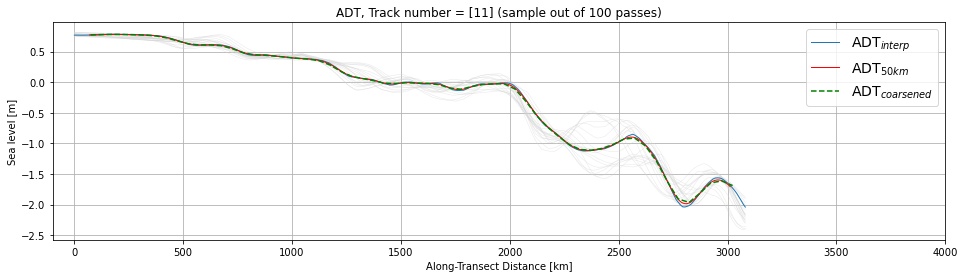

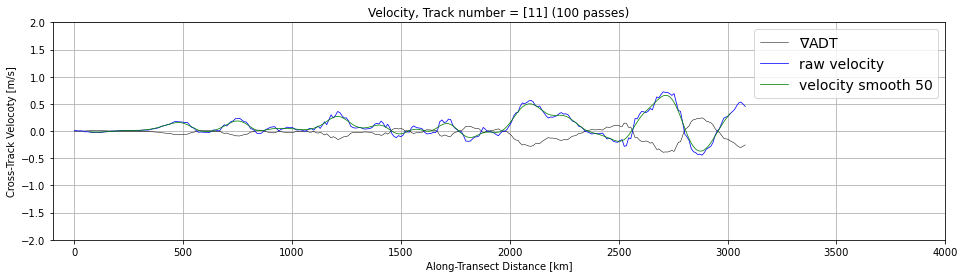

In [92]:
# -- choose a track (to show SLA, Vel, Track Location)
t_i = np.array([11])  # en 3 # J2 24,124,200 # TP 13,15,23 # AL 2  # np.float64(191)  # G2 61, 471
pass_index = 10
save_f = 0
good_indi_dist = np.where(track == t_i)[0][0]
xmax = 4000

f, ax = plt.subplots(1, 1, figsize = (16, 4))
for i in range(np.shape(adt[good_indi_dist])[0]):
    ax.plot(dist[good_indi_dist], adt[good_indi_dist][i, :], linewidth=0.5, color='#D3D3D3', alpha=0.5)
    
eq_region = np.where(np.abs(lat_sim[good_indi_dist]) < 0.1)[0]
if len(eq_region) > 0:
    ax.plot([dist[good_indi_dist][eq_region], dist_sim[good_indi_dist][eq_region]], [-2, 2], color='k', linestyle='--')
    ax.text(dist[good_indi_dist][eq_region][0] + 30, -0.5, 'Equator')
    
for i in range(pass_index, pass_index + 1):
    ax.plot(dist[good_indi_dist], adt[good_indi_dist][i, :], linewidth=1, label=r'ADT$_{interp}$')
    ax.plot(dist[good_indi_dist], adt_smooth[good_indi_dist][i, :], linewidth=1, color='r', label=r'ADT$_{' + str(coarsening_factor0*hor_grid_spacing) + 'km}$')
    ax.plot(dist_coarse[good_indi_dist], adt_coarse[good_indi_dist][pass_index, :], label=r'ADT$_{coarsened}$', linestyle='--', color='g')
ax.set_xlim([-100, xmax])
# ax.set_ylim([-1, 1.5])
ax.set_xlabel('Along-Transect Distance [km]')
ax.set_ylabel('Sea level [m]')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14)
ax.set_title('ADT, Track number = ' + str(t_i) + ' (sample out of ' + str(np.shape(adt[good_indi_dist])[0]) + ' passes)')
ax.grid()
plt.show()
if save_f:
    f.savefig(this_sat + '_sla_track', dpi=300)

f, ax = plt.subplots(1, 1, figsize = (16, 4))
for i in range(pass_index, pass_index + 1):
    ax.plot(dist[good_indi_dist], 50000*adt_grad[good_indi_dist][i, :], linewidth=0.5, color='k', label=r'$\nabla$ADT')
    ax.plot(dist[good_indi_dist], adt_vel[good_indi_dist][i, :], linewidth=0.75, color='b', label='raw velocity')
    ax.plot(dist[good_indi_dist], vel_smooth[good_indi_dist][i, :], linewidth=0.75, color='g', label='velocity smooth 50')
ax.set_xlim([-100, xmax])
ax.set_ylim([-2, 2])
ax.set_xlabel('Along-Transect Distance [km]')
ax.set_ylabel('Cross-Track Velocoty [m/s]')
ax.set_title('Velocity, Track number = ' + str(t_i) + ' (' + str(np.shape(adt[good_indi_dist])[0]) + ' passes)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=14)
ax.grid()
plt.show()
if save_f:
    f.savefig(this_sat + '_velocity_track', dpi=300)

In [94]:
# lat/lon key
for i in range(len(lon_sim)):
    if i < 1:
        lon_t = lon_sim[i]
        lat_t = lat_sim[i]
        track_t = np.ones(len(lon_sim[i])) * track[i]
    else:
        lon_t = np.concatenate((lon_t, lon_sim[i]))
        lat_t = np.concatenate((lat_t, lat_sim[i]))    
        track_t = np.concatenate((track_t, np.ones(len(lon_sim[i])) * track[i]))

In [104]:
# bin variances 
step = 2.5
lon_bins = np.arange(lon_w, lon_e + step, step)
lat_bins = np.arange(lat_s, lat_n + step, step)
lon_bin_c = lon_bins[0:-1] + np.diff(lon_bins)/2
lat_bin_c = lat_bins[0:-1] + np.diff(lat_bins)/2
thresh = 10
mean_sla = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_adt = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_sla_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_adt_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_adt_coarse = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_diff1 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_diff2 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c))) 
mean_v = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))               # velocity from adt
mean_v_anom = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))          # velocity anomaly (temporal)
mean_v_diff = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))          # EKE_1 (u - u_bar)**2
mean_v_diff2 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))         # EKE_2 (u**2 - u_bar**2)
mean_v_diff3 = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))         # cross term (u_bar*u_prime) where u_prime = EKE_1
mean_v_diff3_gaussian = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_slope = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
mean_slope_smooth = np.nan * np.ones((len(lon_bin_c), len(lat_bin_c)))
out_c = 0
for i in tqdm(range(len(lon_bins) - 1)):
    for j in range(len(lat_bins) - 1):
        this_lon0 = lon_bins[i]
        this_lon1 = lon_bins[i+1]
        this_lat0 = lat_bins[j]
        this_lat1 = lat_bins[j+1]
        inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]
        # tracks that fall within this box 
        [ci, ai, bi] = np.intersect1d(track, np.unique(track_t[inn]), return_indices=True)
        count = 0
        for tib in range(len(ai)):
            # for each track that crosses through box, again find subset of grid points in box 
            inn2 = np.where((lon_sim[ai[tib]] > this_lon0) & (lon_sim[ai[tib]] < this_lon1) & (lat_sim[ai[tib]] > this_lat0) & (lat_sim[ai[tib]] < this_lat1))[0]
            # repeat for coarse grid 
            inn2_coarse = np.where((lon_coarse[ai[tib]] > this_lon0) & (lon_coarse[ai[tib]] < this_lon1) & (lat_coarse[ai[tib]] > this_lat0) & (lat_coarse[ai[tib]] < this_lat1))[0]
            
            if count < 1:
                # sla_i = sla[ai[tib]][:, inn2].flatten()
                adt_i = adt[ai[tib]][:, inn2].flatten()
                # sla_smooth_i = sla_smooth[ai[tib]][:, inn2].flatten()
                adt_smooth_i = adt_smooth[ai[tib]][:, inn2].flatten()
                adt_coarse_i = adt_coarse[ai[tib]][:, inn2_coarse].flatten()         # adt coarse
                vel_i = adt_vel[ai[tib]][:, inn2].flatten()                    # velocity from raw sla
                vel_i_anom = (adt_vel[ai[tib]][:, inn2] - np.nanmean(adt_vel[ai[tib]][:, inn2], axis=0)).flatten() # velocity from raw sla
                vel_smooth_i = vel_smooth[ai[tib]][:, inn2].flatten()             # velocity from smoothed raw velocity
                # vel_smooth_g_i = vel_smooth_g_50[ai[tib]][:, inn2].flatten()
                
                count = count + 1
            else:
                # sla_i = np.append(sla_i, sla[ai[tib]][:, inn2].flatten())
                adt_i = np.append(adt_i, adt[ai[tib]][:, inn2].flatten())
                # sla_smooth_i = np.append(sla_smooth_i, sla_smooth[ai[tib]][:, inn2].flatten())
                adt_smooth_i = np.append(adt_smooth_i, adt_smooth[ai[tib]][:, inn2].flatten())
                adt_coarse_i = np.append(adt_coarse_i, adt_coarse[ai[tib]][:, inn2_coarse].flatten())
                vel_i = np.append(vel_i, adt_vel[ai[tib]][:, inn2].flatten())
                vel_i_anom = np.append(vel_i_anom, (adt_vel[ai[tib]][:, inn2] - np.nanmean(adt_vel[ai[tib]][:, inn2], axis=0)).flatten()) 
                vel_smooth_i = np.append(vel_smooth_i, vel_smooth[ai[tib]][:, inn2].flatten())
                # vel_smooth_g_i = np.append(vel_smooth_g_i, vel_smooth_g_50[ai[tib]][:, inn2].flatten())

        # save vel info 
        if out_c < 1:
            cross_out = (vel_smooth_i*(vel_smooth_i - vel_i))
            bar_out = vel_smooth_i
            tot_out = vel_i
            out_c = 1
        else:
            cross_out = np.append(cross_out, (vel_smooth_i*(vel_smooth_i - vel_i)))
            bar_out = np.append(bar_out, vel_smooth_i)
            tot_out = np.append(tot_out, vel_i)

        if (len(ai) > 1):
            if (len(adt_i) > thresh):
                # mean_sla[i, j] = np.nanmean(sla_i**2)           # like a raw eddy energy estimate 
                mean_adt[i, j] = np.nanmean(adt_i)              # raw adt
                # mean_sla_smooth[i, j] = np.nanmean(sla_smooth_i**2)     # smooth sla
                mean_adt_smooth[i, j] = np.nanmean(adt_coarse_i)     # smooth adt
                mean_adt_coarse[i, j] = np.nanmean(adt_coarse_i)     # coarse adt
                # mean_diff1[i, j] = (np.nanmean(adt_i) - np.nanmean(adt_coarse_i))**2   # adt - smooth_adt (like an eddy energy estimate)  (np.nanmean((adt_i - adt_s_i)**2))
                # mean_diff1[i, j] = np.nanmean((sla_i**2 - sla_smooth_i**2))/np.nanmean(sla_i**2)   # adt - smooth_adt (like an eddy energy estimate)  
                # mean_diff2[i, j] = np.nanmean(np.abs((adt_i - adt_s_i)/adt_i))
                
                mean_v[i, j] = np.nanmean(vel_i**2)                                        # calculated from adt gradients 
                mean_v_anom[i, j] = np.nanmean(vel_i_anom**2)                              # temporal EKE def 
                mean_v_diff[i, j] = np.nanmean((vel_i - vel_smooth_i)**2)                  # calculated from coarse sla 
                mean_v_diff2[i, j] = np.nanmean((vel_i**2 - vel_smooth_i**2))              # calculated from coarse sla 
                mean_v_diff3[i, j] = np.nanmean((vel_smooth_i*(vel_smooth_i - vel_i)))     # u_bar*u_prime 
                # mean_v_diff3_gaussian[i, j] = np.nanmean((vel_smooth_g_i*(vel_smooth_g_i - vel_i)))  # u_bar*u_prime 
                # mean_slope[i, j] = np.nanmean(sloper)
                # mean_slope_smooth[i, j] = np.nanmean(sloper1)
        ai = 0

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: Mean of empty slice
  import sys


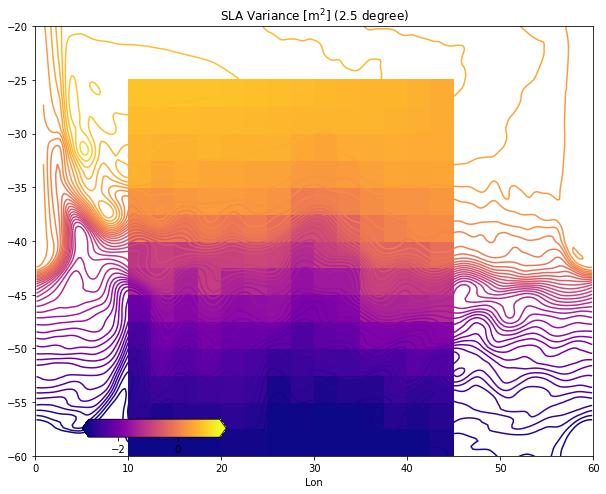

In [128]:
# SLA / ADT 
cbpos = [[0.19, 0.23, 0.2, 0.025], [0.62, 0.23, 0.2, 0.025]]
f, (ax1) = plt.subplots(1, 1, figsize=(10, 10))
adt_lev = np.arange(-3, 1.5, 0.1)

axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_adt), vmin=adt_lev[0], vmax=adt_lev[-1], zorder=0, cmap=plt.get_cmap('plasma'))
ax1.contour(lon, lat, np.nanmean(np.squeeze(x1.e.values[:, 0, :, :]), axis=0), \
            levels=adt_lev, zorder=1, cmap=plt.get_cmap('plasma'), linewidths=1.5) # cmap=plt.get_cmap('plasma'))

ax1.set_xlabel('Lon')
ax1.set_title(r'SLA Variance [m$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([0, 60])
ax1.set_ylim([-60, -20])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')

# adt_lev = np.arange(-1, 2, 0.1)
# ax2.scatter(x4['lon'].values, x4['lat'].values, color='w', zorder=1, s=0.1)
# axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_adt), vmin=adt_lev[0], vmax=adt_lev[-1], zorder=0, cmap=plt.get_cmap('plasma'))
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_adt), levels=adt_lev, colors='k', linewidths=0.5)
# ax2.set_xlabel('Lon')
# ax2.set_title(r'average ADT [m] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
# ax2.set_xlim([lon_w, lon_e])
# ax2.set_ylim([lat_s, lat_n])
# w = 1 / np.cos(np.deg2rad(30))
# ax2.set_aspect(w)
# cax = f.add_axes(cbpos[1])
# cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()

In [196]:
load_mod = pickle.load(open('/Users/jakesteinberg/Desktop/neverworld/neverworld_vel_filt.p', 'rb'))
# mod lat lon should be same as that already loaded, just want eke 
eke_mod = load_mod['eke']
eke2_mod = load_mod['eke2']

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:45: RuntimeWarning: Mean of empty slice


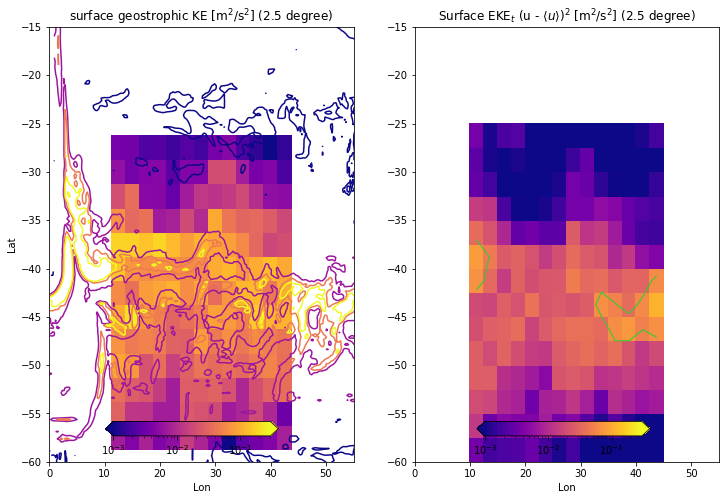

/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:78: RuntimeWarning: Mean of empty slice
/Users/jakesteinberg/anaconda3/envs/cpt/lib/python3.7/site-packages/ipykernel_launcher.py:97: UserWarning: No contour levels were found within the data range.


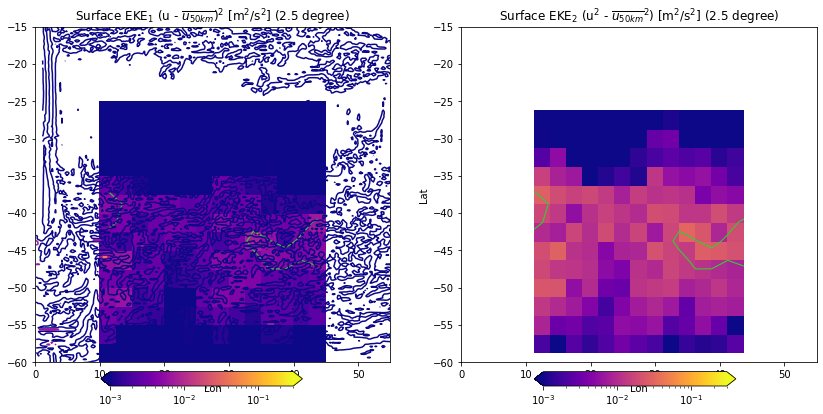

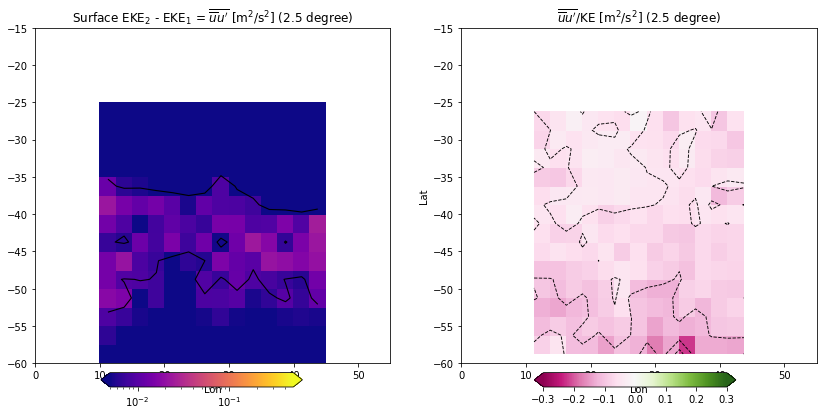

In [204]:
from matplotlib.colors import LogNorm
# sla velocity and adt velocity 
# plot, excluding equator 
v_in = np.where((lat_bin_c > -10) & (lat_bin_c < 10))[0]
# total KE 
mean_v_mask = mean_v.copy()
mean_v_mask[:, v_in] = np.nan
# EKE time
mean_v_mask_time = mean_v_anom.copy()
mean_v_mask_time[:, v_in] = np.nan
# EKE 1
mean_v_tot_mask = mean_v_diff.copy()
mean_v_tot_mask[:, v_in] = np.nan
# EKE 2
mean_v_tot_mask2 = mean_v_diff2.copy()
mean_v_tot_mask2[:, v_in] = np.nan
mean_v_tot_mask2_negative_eke = np.transpose(mean_v_tot_mask2.copy())
Lon_c, Lat_c = np.meshgrid(lon_bin_c, lat_bin_c)
Lon_c[mean_v_tot_mask2_negative_eke >= 0] = np.nan
Lat_c[mean_v_tot_mask2_negative_eke >= 0] = np.nan
Lon_c[np.isnan(np.transpose(mean_v_mask))] = np.nan
Lat_c[np.isnan(np.transpose(mean_v_mask))] = np.nan
# EKE cross term
mean_v_tot_mask3 = mean_v_diff3.copy()
mean_v_tot_mask3[:, v_in] = np.nan
# mean_v_tot_mask3_g = mean_v_diff3_gaussian.copy()
# mean_v_tot_mask3_g[:, v_in] = np.nan

save_f = 0 
lon_w2 = lon_w - 10
lon_e2 = lon_e + 10
lat_s2 = lat_s
lat_n2 = lat_n + 10

# --------------- fig 1
cbpos = [[0.19, 0.17, 0.2, 0.025], [0.62, 0.17, 0.2, 0.025]]
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
levs = np.arange(0.001, 0.4, 0.01)
levs = np.arange(levs[0], levs[-1], 0.1)
levs2 = [0.35]  
levs3 = [0.05]
levs4 = [0.025]
axp = ax1.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap='plasma')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
ax1.contour(lon, lat, np.nanmean(np.squeeze(x1.KE.values[0:20, 0, :, :]), axis=0), levels=levs, cmap='plasma')
ax1.set_xlabel('Lon')
ax1.set_ylabel('Lat')
ax1.set_title(r'surface geostrophic KE [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w2, lon_e2])
ax1.set_ylim([lat_s2, lat_n2])
# w = 1 / np.cos(np.deg2rad(30))
# ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')

axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(mean_v_mask_time), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=0.9, colors='k')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs4, zorder=1, linewidths=1.1, colors='k')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs2, zorder=1, linewidths=0.9, colors='limegreen')
ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs3, zorder=1, linewidths=1.1, colors='limegreen')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs4, zorder=1, linewidths=1.1, colors='limegreen')
ax2.set_xlabel('Lon')
ax2.set_title(r'Surface EKE$_{t}$ (u - $\left< u \right>$)$^2$ [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w2, lon_e2])
ax2.set_ylim([lat_s2, lat_n2])
# w = 1 / np.cos(np.deg2rad(30))
# ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/neverworld/neverworld_altim_mean_ke.jpg', dpi=300)

# --------- fig 2
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
# EKE 1 
axp = ax1.pcolor(lon_bins, lat_bins, np.transpose(mean_v_tot_mask), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
ax1.contour(lon, lat, np.nanmean(np.squeeze(eke_mod[0:20, :, :]), axis=0), levels=levs, cmap='plasma')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=0.9, colors='k')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs4, zorder=1, linewidths=1.1, colors='k')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs2, zorder=1, linewidths=0.9, colors='limegreen')
ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs3, zorder=1, linewidths=1.1, colors='limegreen')
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs4, zorder=1, linewidths=1.1, colors='limegreen')
ax1.set_xlabel('Lon')
ax1.set_title(r'Surface EKE$_1$ (u - $\overline{u_{50km}}$)$^2$ [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w2, lon_e2])
ax1.set_ylim([lat_s2, lat_n2])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
# EKE 2 
axp = ax2.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), norm=LogNorm(vmin=levs[0], vmax=levs[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
ax2.scatter(Lon_c.flatten(), Lat_c.flatten(), s=50, color='r')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), levels=levs2, zorder=1, linewidths=0.9, colors='k')
ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask2), levels=levs3, zorder=1, linewidths=1.1, colors='k')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs2, zorder=1, linewidths=0.9, colors='limegreen')
ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs3, zorder=1, linewidths=1.1, colors='limegreen')
# ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask_time), levels=levs4, zorder=1, linewidths=1.1, colors='limegreen')
ax2.set_xlabel('Lon')
ax2.set_ylabel('Lat')
ax2.set_title(r'Surface EKE$_2$ (u$^2$ - $\overline{u_{50km}}^2$) [m$^2$/s$^2$] (' + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w2, lon_e2])
ax2.set_ylim([lat_s2, lat_n2])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
if save_f:
    f.savefig(this_sat + '_vel_eke_2.jpg', dpi=300)


# --------- fig 3
# levs2 = np.arange(0.035, 0.036, 0.01)
levs_cross = np.arange(0.005, 0.5, 0.01)
levs_frac = np.arange(-0.3, 0.35, 0.05)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

# EKE 2 - EKE 1 (should equal the cross term)
axp2 = ax1.pcolor(lon_bins, lat_bins, np.transpose(np.abs(mean_v_tot_mask2 - mean_v_tot_mask)), norm=LogNorm(vmin=levs_cross[0], vmax=levs_cross[-1]), zorder=0, cmap=plt.get_cmap('plasma'))
# axp = ax2.pcolor(lon_bins, lat_bins, np.transpose(np.abs((mean_v_tot_mask2 - mean_v_tot_mask)/mean_v_tot_mask3)), vmin=1.75, vmax=2.25, zorder=0, cmap=plt.get_cmap('PiYG'))
# ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs2, zorder=1, linewidths=0.9, colors='k')
ax1.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_mask), levels=levs3, zorder=1, linewidths=1.1, colors='k')
ax1.set_xlabel('Lon')
ax1.set_title(r"Surface EKE$_2$ - EKE$_1$ = $\overline{\overline{u}u'}$ [m$^2$/s$^2$] (" + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax1.set_xlim([lon_w2, lon_e2])
ax1.set_ylim([lat_s2, lat_n2])
w = 1 / np.cos(np.deg2rad(30))
ax1.set_aspect(w)
cax = f.add_axes(cbpos[0])
cb = f.colorbar(axp2, cax=cax, orientation='horizontal', extend='both')

# cross term as a fraction
axp = ax2.pcolor(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask3/mean_v_mask), vmin=levs_frac[0], vmax=levs_frac[-1], zorder=0, cmap=plt.get_cmap('PiYG'))
ax2.contour(lon_bin_c, lat_bin_c, np.transpose(mean_v_tot_mask3/mean_v_mask), levels=levs_frac, zorder=1, linewidths=0.9, colors='k')
ax2.set_xlabel('Lon')
ax2.set_ylabel('Lat')
ax2.set_title(r"$\overline{\overline{u}u'}$/KE [m$^2$/s$^2$] (" + str(step) + ' degree)') #  smoothed to ' + str(coarsening_factor*hor_grid_spacing) + 'km')
ax2.set_xlim([lon_w2, lon_e2])
ax2.set_ylim([lat_s2, lat_n2])
w = 1 / np.cos(np.deg2rad(30))
ax2.set_aspect(w)
cax = f.add_axes(cbpos[1])
cb = f.colorbar(axp, cax=cax, orientation='horizontal', extend='both')
plt.show()
if save_f:
    f.savefig(this_sat + '_vel_eke_3.jpg', dpi=300)

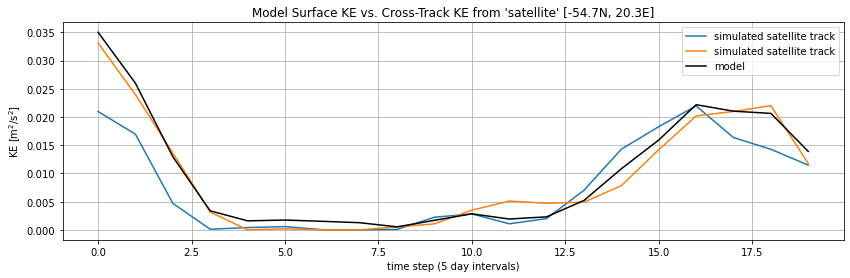

In [201]:
# KE from model, sat at lon 
this_lon0 = 20.1
this_lon1 = 20.5
this_lat0 = -54.9
this_lat1 = -54.5
# define small box and find which tracks fall in box 
inn = np.where((lon_t > this_lon0) & (lon_t < this_lon1) & (lat_t > this_lat0) & (lat_t < this_lat1))[0]

in_mod_lon = np.where((lon > this_lon0) & (lon < this_lon1))[0]
in_mod_lat = np.where((lat > this_lat0) & (lat < this_lat1))[0]
this_mod_ke = x1.KE.values[0:20, 0]
this_mod_ke_sub = this_mod_ke[:, in_mod_lat, :]
this_mod_ke_sub = this_mod_ke_sub[:, :, in_mod_lon]
# tracks that fall within this box 
[ci, ai, bi] = np.intersect1d(track, np.unique(track_t[inn]), return_indices=True)
count = 0
f, ax = plt.subplots(1,1,figsize=(14, 4))
for tib in range(len(ai)):
    # for each track that crosses through box, again find subset of grid points in box 
    inn2 = np.where((lon_sim[ai[tib]] > this_lon0) & (lon_sim[ai[tib]] < this_lon1) & (lat_sim[ai[tib]] > this_lat0) & (lat_sim[ai[tib]] < this_lat1))[0]
    vel_i = adt_vel[ai[tib]][:, inn2[0]]
    ax.plot(np.arange(0, np.shape(vel_i)[0]), vel_i**2, label='simulated satellite track')
ax.plot(np.arange(0, 20), np.nanmean(np.nanmean(this_mod_ke_sub,axis=1),axis=1), color='k', label='model')
ax.set_xlabel('time step (5 day intervals)')
ax.set_ylabel('KE [m$^2$/s$^2$]')
ax.set_title("Model Surface KE vs. Cross-Track KE from 'satellite' [" + \
             str(np.nanmean([this_lat0, this_lat1])) + "N, " + str(np.nanmean([this_lon0, this_lon1])) + "E]")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, fontsize=10)
ax.grid()
plt.show()
f.savefig('/Users/jakesteinberg/Desktop/neverworld/neverworld_altim_ke_timeseries.jpg', dpi=300)

In [167]:
np.shape(this_mod_ke_sub)

(20, 2, 2)

In [138]:
vel_i

array([ 0.1344933 ,  0.1309642 ,  0.04826352, -0.01465678, -0.01746556,
       -0.01389025, -0.00379487, -0.01817894, -0.05199149, -0.08552816,
       -0.08213786, -0.0640449 , -0.07519901, -0.05200504, -0.01242057,
        0.00603803,  0.06113139,  0.06542147, -0.00031437, -0.02350222,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,         nan,
               nan,         nan,         nan,         nan,      